# CART决策树回归算法复现

In [29]:
import numpy as np
from sklearn.tree import DecisionTreeRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score,mean_squared_error
import pandas as pd
import random
import matplotlib.pyplot as plt 
plt.rcParams['font.sans-serif'] = ['SimHei']
plt.rcParams['axes.unicode_minus'] = False

In [31]:
### CART算法的节点类
class Node:
    def __init__(self, feature, threshold, left, right):
        self.feature = feature
        self.threshold = threshold
        self.left = left
        self.right = right
## CART 回归树类
class DecisionTree_Regressor:
    def __init__(self,max_depth = 1000,criterion = 'mse',min_samples_split = 2,min_samples_leaf=2,random_state=42) -> None:
        self.max_depth = max_depth #树的最大深度，用于控制树的复杂度和防止过拟合。
        self.criterion = criterion #用于衡量节点分裂的好坏，常见的评估准则有均方误差（MSE）和平均绝对误差（MAE）。
        self.min_samples_split = min_samples_split #指定拆分内部节点所需的最小样本数，用于控制树的生长过程。
        self.random_state = random_state #用于控制模型的随机性，指定相同的随机种子可以保证模型具有可重复性
        self.min_samples_leaf = min_samples_leaf #指定叶子节点所需的最小样本数，用于控制树的生长过程。
    ## 计算MSE
    def cal_mse(self,x):
        if len(x)==0:
            return 0
        mean = np.mean(x) ##首先计算平均值
        mse = np.mean((x-mean)**2) ##均方误差
        return mse
    
    ## 计算左右分支均方误差的和
    def sum_mse(self,y,y_left,y_right):
        n = len(y)
        n_left,n_right = len(y_left),len(y_right)
        mse_sum = (n_left) /n*self.cal_mse(y_left) +(n_right)/n*self.cal_mse(y_right)
        return mse_sum
    
    def result_y(self,y):
        return np.mean(y)
    
    def build_tree(self,X,y,depth=0):    
        n_samples,n_features = X.shape ##获取数据特征的个数
        n_labels = len(np.unique(y)) #获取因变量的种类个数
        if depth >= self.max_depth or n_labels == 1 or n_samples<self.min_samples_split: ##如果二叉树的分支大于默认的最大分支个数或者因变量的标签种类个数为1
            return self.result_y(y) ##返回标签中样本数最多的类别
        best_mse =np.inf
        best_feature = None
        best_threshold = None
        random.seed(self.random_state)
        n_features = random.sample(range(n_features),n_features)
        for feature_idx in n_features:
            thresholds = np.unique(X[:,feature_idx])
            for threshold in thresholds:
                left_idx = np.argwhere(X[:,feature_idx]<=threshold).flatten()
                right_idx = np.argwhere(X[:,feature_idx]>threshold).flatten()
                if len(left_idx) == 0 or len(right_idx) == 0:
                    continue
                temp_mse = self.sum_mse(y,y[left_idx],y[right_idx])
                if temp_mse<best_mse:
                    best_mse = temp_mse
                    best_feature = feature_idx
                    best_threshold = threshold
        left_idxs = np.argwhere(X[:,best_feature] <=best_threshold).flatten() 
        right_idxs = np.argwhere(X[:,best_feature]>best_threshold).flatten()
        if len(left_idxs) <self.min_samples_leaf or len(right_idxs) <self.min_samples_leaf:
            return self.result_y(y)
        left_tree = self.build_tree(X[left_idxs,:],y[left_idxs],depth+1)
        right_tree = self.build_tree(X[right_idxs,:],y[right_idxs],depth+1)
        return Node(best_feature,best_threshold,left_tree,right_tree)
    
    def fit(self,X,y):
        self.tree = self.build_tree(X,y)
        return self.tree
    
    def _predict(self,inputs):
        node = self.tree
        while isinstance(node,Node):
            if inputs[node.feature]<=node.threshold:
                node = node.left
            else:
                node = node.right
        return node
    
    def predict(self,X):
        results = [self._predict(x) for x in X]
        return np.array(results)
    
        

# 波士顿房价回归预测

In [32]:
#导入波士顿房价数据集
data = pd.read_csv('data/boston.csv')
data = data.values
x = data[:,:-1]
y = data[:,-1]
X_train,X_test,y_train,y_test = train_test_split(x,y,test_size=0.2,random_state=42)

In [40]:
test_model = DecisionTree_Regressor(random_state=10)
test_model.fit(X_train,y_train)
y_pre = test_model.predict(X_test)
r2 = r2_score(y_test,y_pre)
mse = mean_squared_error(y_test,y_pre)
print('自编算法的回归模型的决定系数为：{:5f},平均误差平方：{:5f}'.format(r2,mse))

sklearn_model = DecisionTreeRegressor(random_state=10)
sklearn_model.fit(X_train,y_train)
y_pre_skl= sklearn_model.predict(X_test)
r2_skl = r2_score(y_test,y_pre_skl)
mse_skl = mean_squared_error(y_pre_skl,y_test)
print('sklearn决策树回归模型的决定系数为：{:5f},平均误差平方：{:5f}'.format(r2_skl,mse_skl))

自编算法的回归模型的决定系数为：0.857398,平均误差平方：10.457579
sklearn决策树回归模型的决定系数为：0.722413,平均误差平方：20.356471


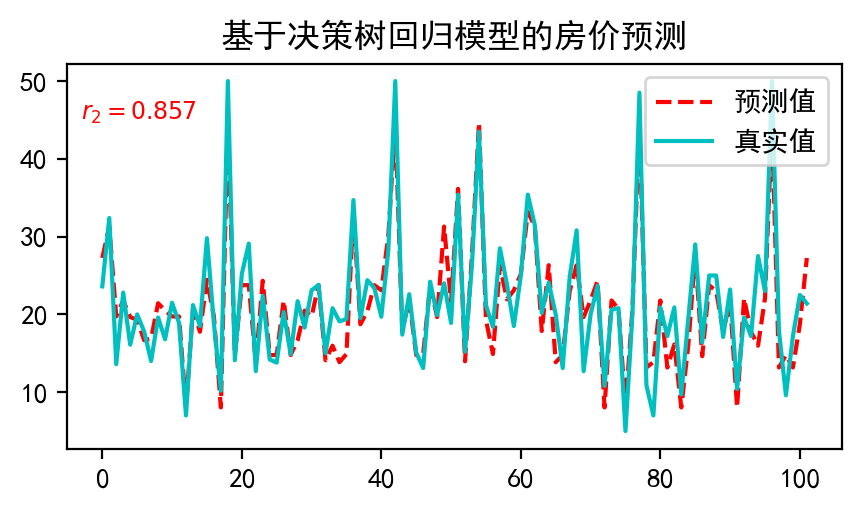

In [41]:
plt.figure(figsize=(5,2.5),dpi=200)
plt.plot(y_pre,'r--',label='预测值')
plt.plot(y_test,'c',label='真实值')
plt.text(x=-3,y=45,s='$r_2 =0.857$',fontsize = 8.5,color='red')
plt.legend()
plt.title('基于决策树回归模型的房价预测')
plt.savefig('Images/决策树回归房价预测.png')
plt.show()

# 